In [1]:
%matplotlib notebook
import gmaps
import matplotlib.pyplot as plt
import pandas as pd
import requests

from config import gkey,api_key
from census import Census

def coordinates(loc):
    params = {"address": loc, "key":gkey}
    base_url = "https://maps.googleapis.com/maps/api/geocode/json"
    response = requests.get(base_url, params = params)
    place_geo = response.json()
    lat = place_geo['results'][0]["geometry"]['location']['lat']
    lng = place_geo['results'][0]["geometry"]['location']['lng']
    return lat, lng

c = Census(api_key, year=2018)
gmaps.configure(api_key = gkey)

In [2]:
df = pd.read_excel("Tables/Table_13_Hate_Crime_Incidents_per_Bias_Motivation_and_Quarter_by_State_and_Agency_2018.xlsm")
df.dropna(inplace=True)
ls = []
for x in df["Agency name"]:
    if '3' in x:
        #print(x)
        ls.append(x[:-1])
    else:
        ls.append(x)
df["Agency name"] = ls
df.head()

,State,Agency,Agency name,Race/Ethnicity/Ancestry,Religion,Sexual Orientation,Disability,Gender,Gender identity,1st quarter,2nd quarter,3rd quarter,4th quarter,Population
2,Alaska,Cities,Anchorage,1,0,0,0,0,0,0.0,0,1.0,0.0,291992.0
3,Alaska,Cities,Fairbanks,2,0,0,1,0,0,1.0,1,1.0,0.0,31635.0
4,Alaska,Cities,Juneau,0,2,0,0,0,0,0.0,0,2.0,0.0,31922.0
5,Alaska,Cities,Kotzebue,1,0,0,0,0,0,0.0,1,0.0,0.0,3273.0
9,Arizona,Cities,Coolidge,2,0,0,0,0,0,0.0,0,0.0,2.0,12815.0


In [3]:
dfloc = pd.read_csv("locations.csv")
dfloc["Loc"] = dfloc["State"] + "," + dfloc["Agency name"]

df["Loc"] = df["State"] + "," + df["Agency name"]
dfa = pd.merge(df,dfloc,on=["Loc","Loc"])
dfa = dfa.loc[:,['Loc', 'Lat', 'Lng','Population', 'Race/Ethnicity/Ancestry',
       'Religion', 'Sexual Orientation', 'Disability', 'Gender',
       'Gender identity']]
dfa["Total"] = dfa["Race/Ethnicity/Ancestry"] + dfa["Religion"] + dfa["Gender"] + dfa["Gender identity"] + dfa["Disability"]
loc = dfa.loc[:,["Lat","Lng"]]

In [16]:
# results saved to file locations.csv, not worth re-running outside of error
'''
df["Lat"] = ""
df["Lng"] = ""
for i,r in df.iterrows():
    st = r[2] + ',' + r[0]
    lat,lng = coordinates(st)
    df.loc[i,["Lat"]] = lat
    df.loc[i,["Lng"]] = lng

dfloc = df.loc[:,['State', 'Agency name', 'Lat', 'Lng']]

dfloc.to_csv("locations.csv")
'''

'\ndf["Lat"] = ""\ndf["Lng"] = ""\nfor i,r in df.iterrows():\n    st = r[2] + \',\' + r[0]\n    lat,lng = coordinates(st)\n    df.loc[i,["Lat"]] = lat\n    df.loc[i,["Lng"]] = lng\n\ndfloc = df.loc[:,[\'State\', \'Agency name\', \'Lat\', \'Lng\']]\n\ndfloc.to_csv("locations.csv")\n'

<IPython.core.display.Javascript object>


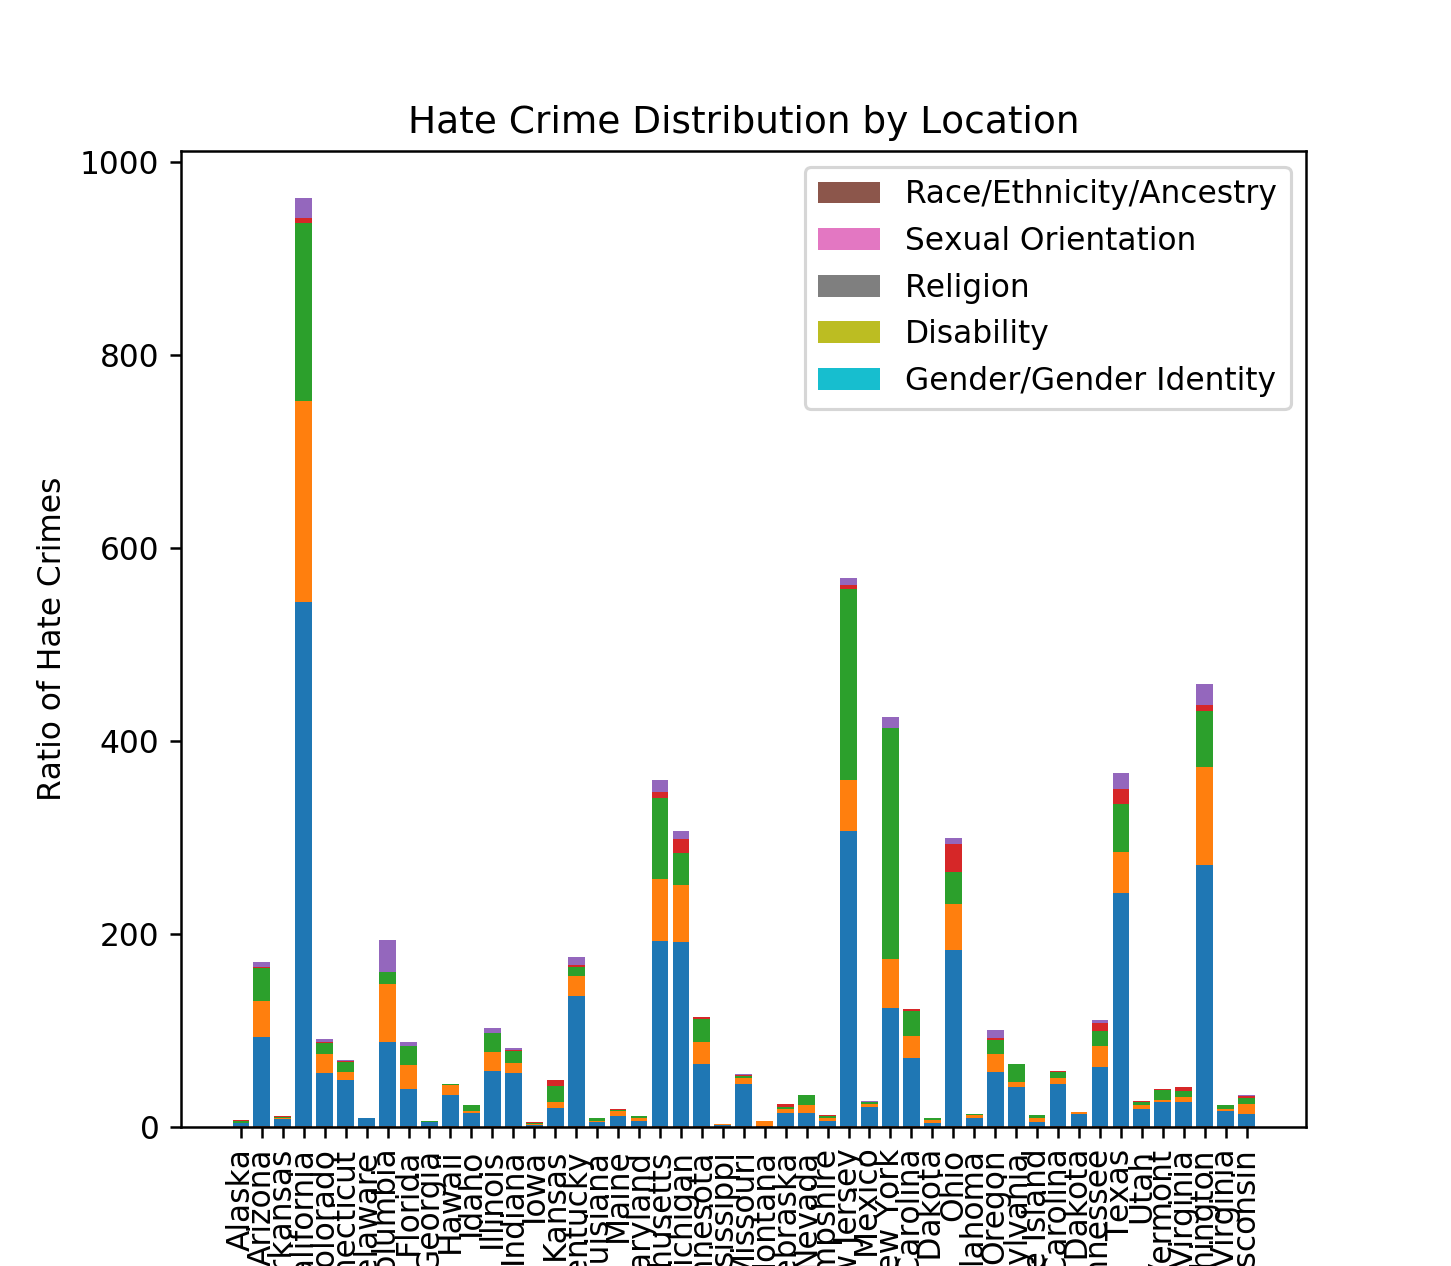

In [5]:
dfg = df.groupby("State").sum()
dfg.loc[:,['Race/Ethnicity/Ancestry', 'Religion', 'Sexual Orientation',
       'Disability', 'Gender', 'Gender identity']]
dfg["Total"] = dfg["Race/Ethnicity/Ancestry"] + dfg["Religion"] + dfg["Gender"] + dfg["Gender identity"] + dfg["Disability"] + dfg["Sexual Orientation"]

race = plt.bar(range(dfg.shape[0]),dfg["Race/Ethnicity/Ancestry"])
sex  = plt.bar(range(dfg.shape[0]),dfg["Sexual Orientation"],bottom=dfg["Race/Ethnicity/Ancestry"])
rel  = plt.bar(range(dfg.shape[0]),dfg["Religion"], bottom = dfg["Race/Ethnicity/Ancestry"]+ dfg["Sexual Orientation"])
dis  = plt.bar(range(dfg.shape[0]),dfg["Disability"], bottom = dfg["Race/Ethnicity/Ancestry"] + dfg["Sexual Orientation"]+ dfg["Religion"])
gen  = plt.bar(range(dfg.shape[0]),dfg["Gender"] + dfg["Gender identity"], bottom = dfg["Race/Ethnicity/Ancestry"]+ dfg["Sexual Orientation"] + dfg["Religion"] + dfg["Disability"])

ind = list(dfg.index)
plt.xticks(range(dfg.shape[0]),labels=ind, rotation = 90)
plt.title("Hate Crimes by Location")
plt.legend((race,sex,rel,dis,gen),("Race/Ethnicity/Ancestry","Sexual Orientation","Religion","Disability","Gender/Gender Identity"))
plt.ylabel("Number of Hate Crimes")
plt.xlabel("Location")
plt.show()

<IPython.core.display.Javascript object>


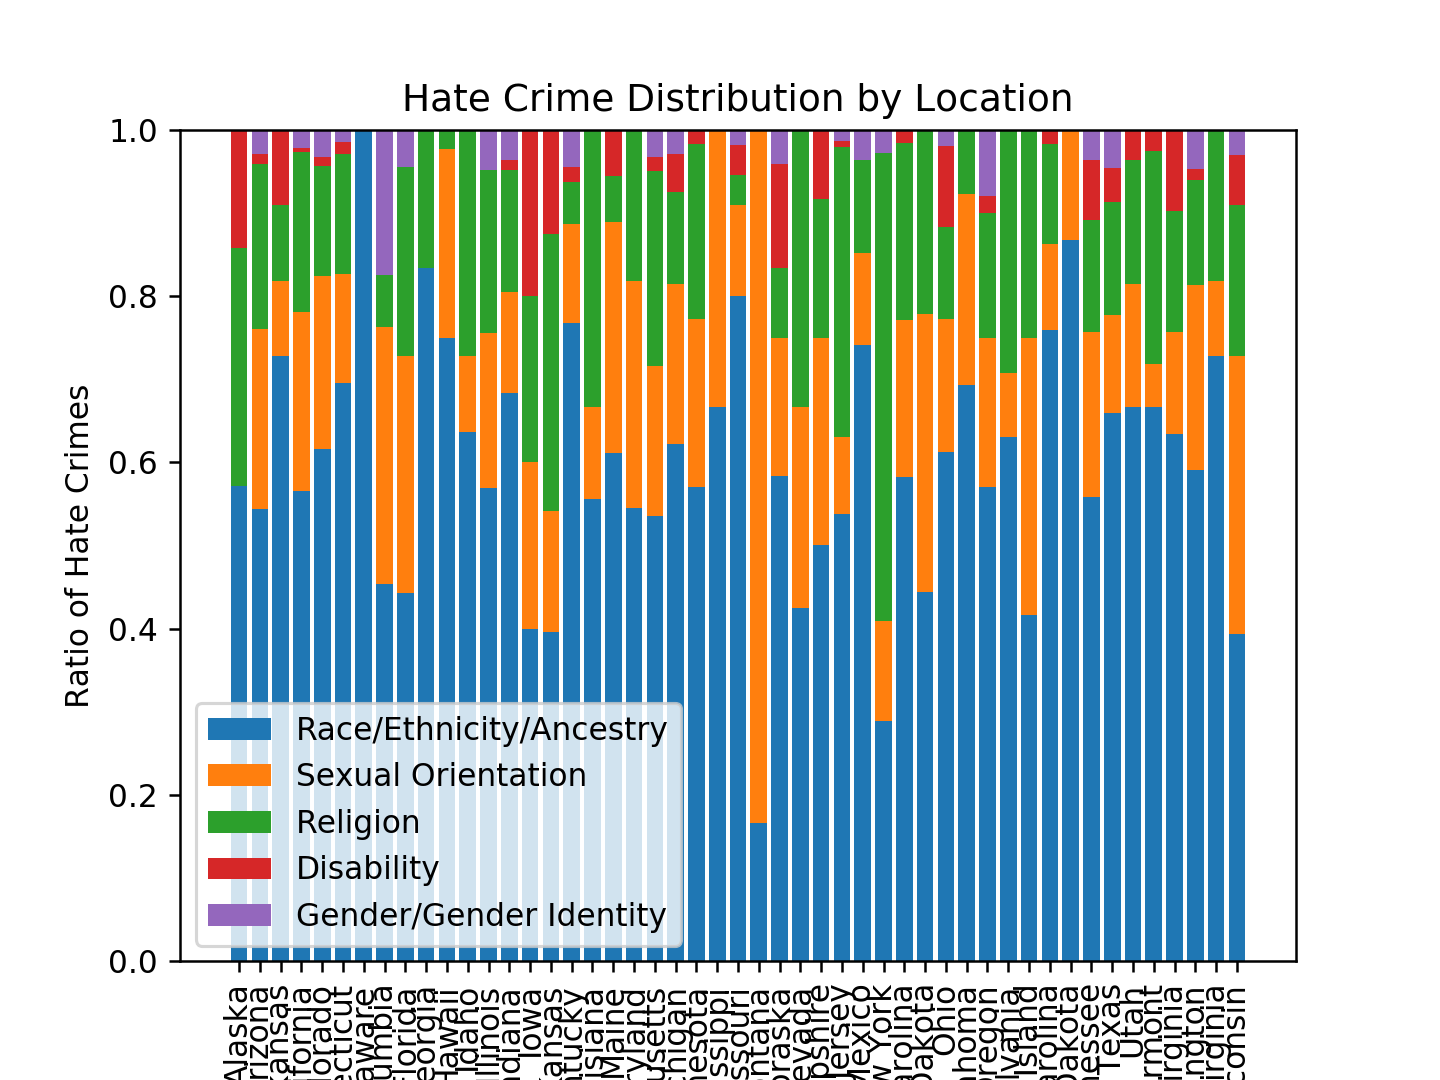

In [7]:
dfgp = dfg.loc[:,['Race/Ethnicity/Ancestry', 'Religion', 'Sexual Orientation',
       'Disability', 'Gender', 'Gender identity', 'Population', 'Total']]
dfgp["Race/Ethnicity/Ancestry"] = dfg["Race/Ethnicity/Ancestry"]/dfg["Total"]
dfgp["Disability"] = dfg["Disability"]/dfg["Total"]
dfgp["Religion"] = dfg["Religion"]/dfg["Total"]
dfgp["Gender identity"] = dfg["Gender identity"]/dfg["Total"]
dfgp["Gender"] = dfg["Gender"]/dfg["Total"]
dfgp["Sexual Orientation"] = dfg["Sexual Orientation"]/dfg["Total"]


race = plt.bar(range(dfg.shape[0]),dfgp["Race/Ethnicity/Ancestry"])
sex = plt.bar(range(dfg.shape[0]),dfgp["Sexual Orientation"],bottom=dfgp["Race/Ethnicity/Ancestry"])
rel = plt.bar(range(dfg.shape[0]),dfgp["Religion"], bottom = dfgp["Race/Ethnicity/Ancestry"]+ dfgp["Sexual Orientation"])
dis = plt.bar(range(dfg.shape[0]),dfgp["Disability"], bottom = dfgp["Race/Ethnicity/Ancestry"] + dfgp["Sexual Orientation"]+ dfgp["Religion"])
gen = plt.bar(range(dfg.shape[0]),dfgp["Gender"] + dfgp["Gender identity"], bottom = dfgp["Race/Ethnicity/Ancestry"]+ dfgp["Sexual Orientation"] + dfgp["Religion"] + dfgp["Disability"])

ind = list(dfg.index)
plt.xticks(range(dfg.shape[0]),labels=ind, rotation = 90)
plt.title("Hate Crime Distribution by Location")
plt.legend((race,sex,rel,dis,gen),("Race/Ethnicity/Ancestry","Sexual Orientation","Religion","Disability","Gender/Gender Identity"))
plt.ylabel("Ratio of Hate Crimes")
plt.xlabel("Location")
plt.show()


<IPython.core.display.Javascript object>


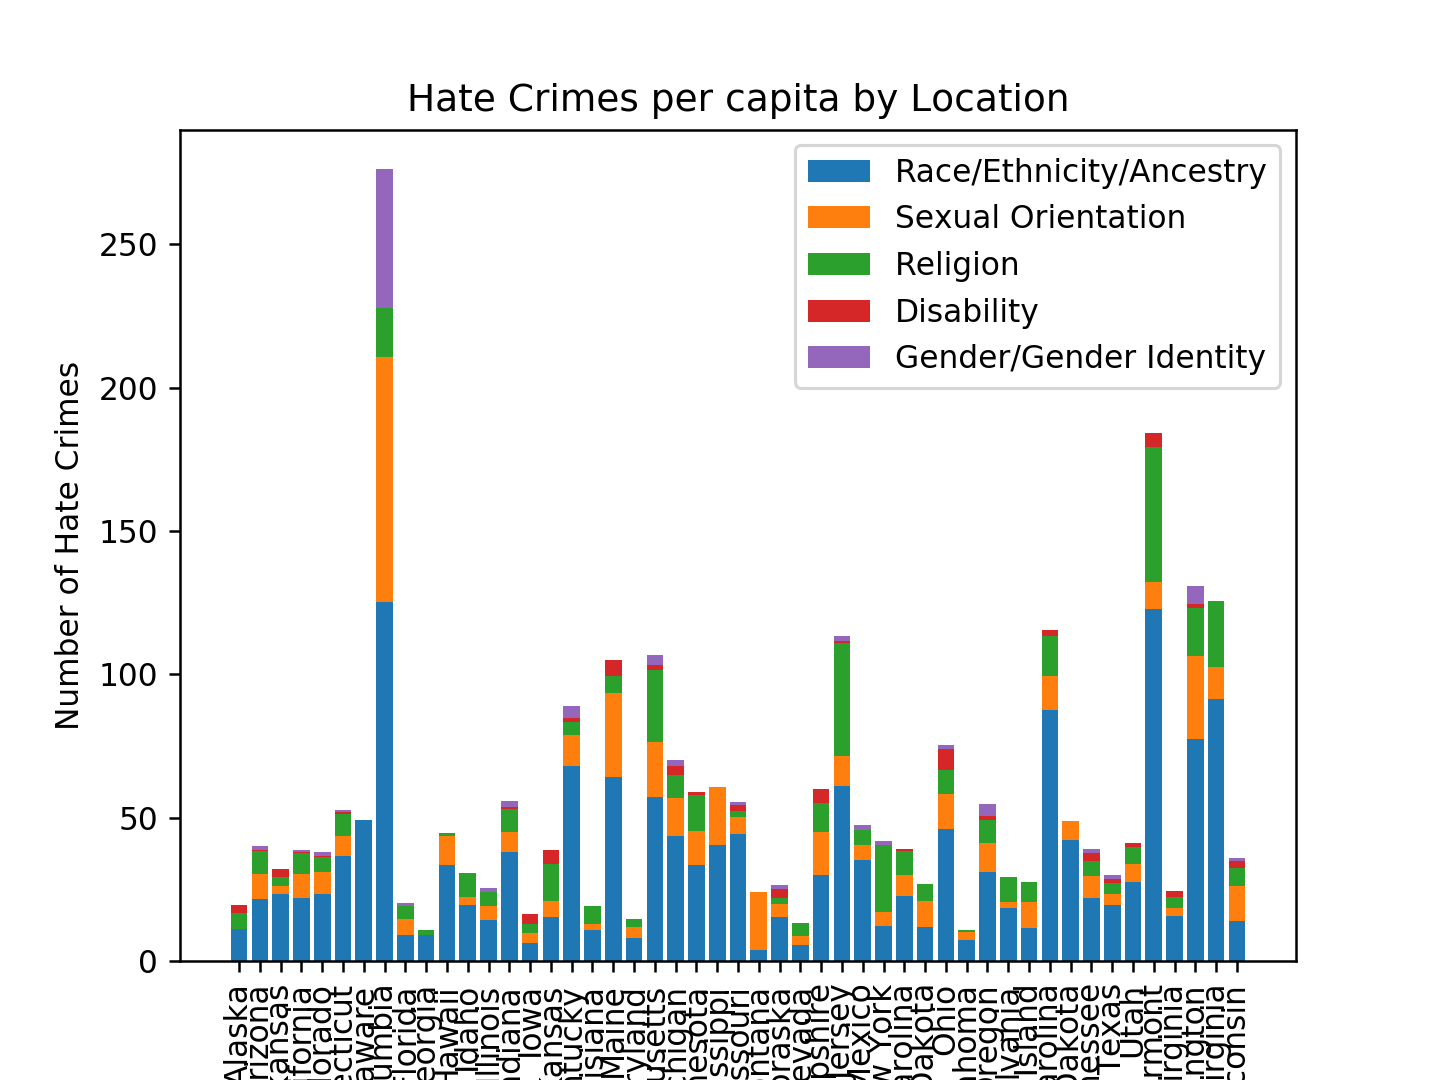

In [41]:
dfgpop = dfg.loc[:,['Race/Ethnicity/Ancestry', 'Religion', 'Sexual Orientation',
       'Disability', 'Gender', 'Gender identity', 'Population', 'Total']]
dfgpop["Race/Ethnicity/Ancestry"] = dfg["Race/Ethnicity/Ancestry"]/dfg["Population"]
dfgpop["Disability"] = dfg["Disability"]/dfg["Population"]
dfgpop["Religion"] = dfg["Religion"]/dfg["Population"]
dfgpop["Gender identity"] = dfg["Gender identity"]/dfg["Population"]
dfgpop["Gender"] = dfg["Gender"]/dfg["Population"]
dfgpop["Sexual Orientation"] = dfg["Sexual Orientation"]/dfg["Population"]
dfgpop = dfgpop.loc[:,['Race/Ethnicity/Ancestry', 'Religion', 'Sexual Orientation','Disability', 'Gender', 'Gender identity']] * 1000000

race = plt.bar(range(dfg.shape[0]),dfgpop["Race/Ethnicity/Ancestry"])
sex = plt.bar(range(dfg.shape[0]),dfgpop["Sexual Orientation"],bottom=dfgpop["Race/Ethnicity/Ancestry"])
rel = plt.bar(range(dfg.shape[0]),dfgpop["Religion"], bottom = dfgpop["Race/Ethnicity/Ancestry"]+ dfgpop["Sexual Orientation"])
dis = plt.bar(range(dfg.shape[0]),dfgpop["Disability"], bottom = dfgpop["Race/Ethnicity/Ancestry"] + dfgpop["Sexual Orientation"]+ dfgpop["Religion"])
gen = plt.bar(range(dfg.shape[0]),dfgpop["Gender"] + dfgpop["Gender identity"], bottom = dfgpop["Race/Ethnicity/Ancestry"]+ dfgpop["Sexual Orientation"] + dfgpop["Religion"] + dfgpop["Disability"])

ind = list(dfg.index)
plt.xticks(range(dfg.shape[0]),labels=ind, rotation = 90)
plt.title("Hate Crimes per capita by Location")
plt.legend((race,sex,rel,dis,gen),("Race/Ethnicity/Ancestry","Sexual Orientation","Religion","Disability","Gender/Gender Identity"))
plt.ylabel("Number of Hate Crimes")
plt.xlabel("Location")
plt.show()

<IPython.core.display.Javascript object>


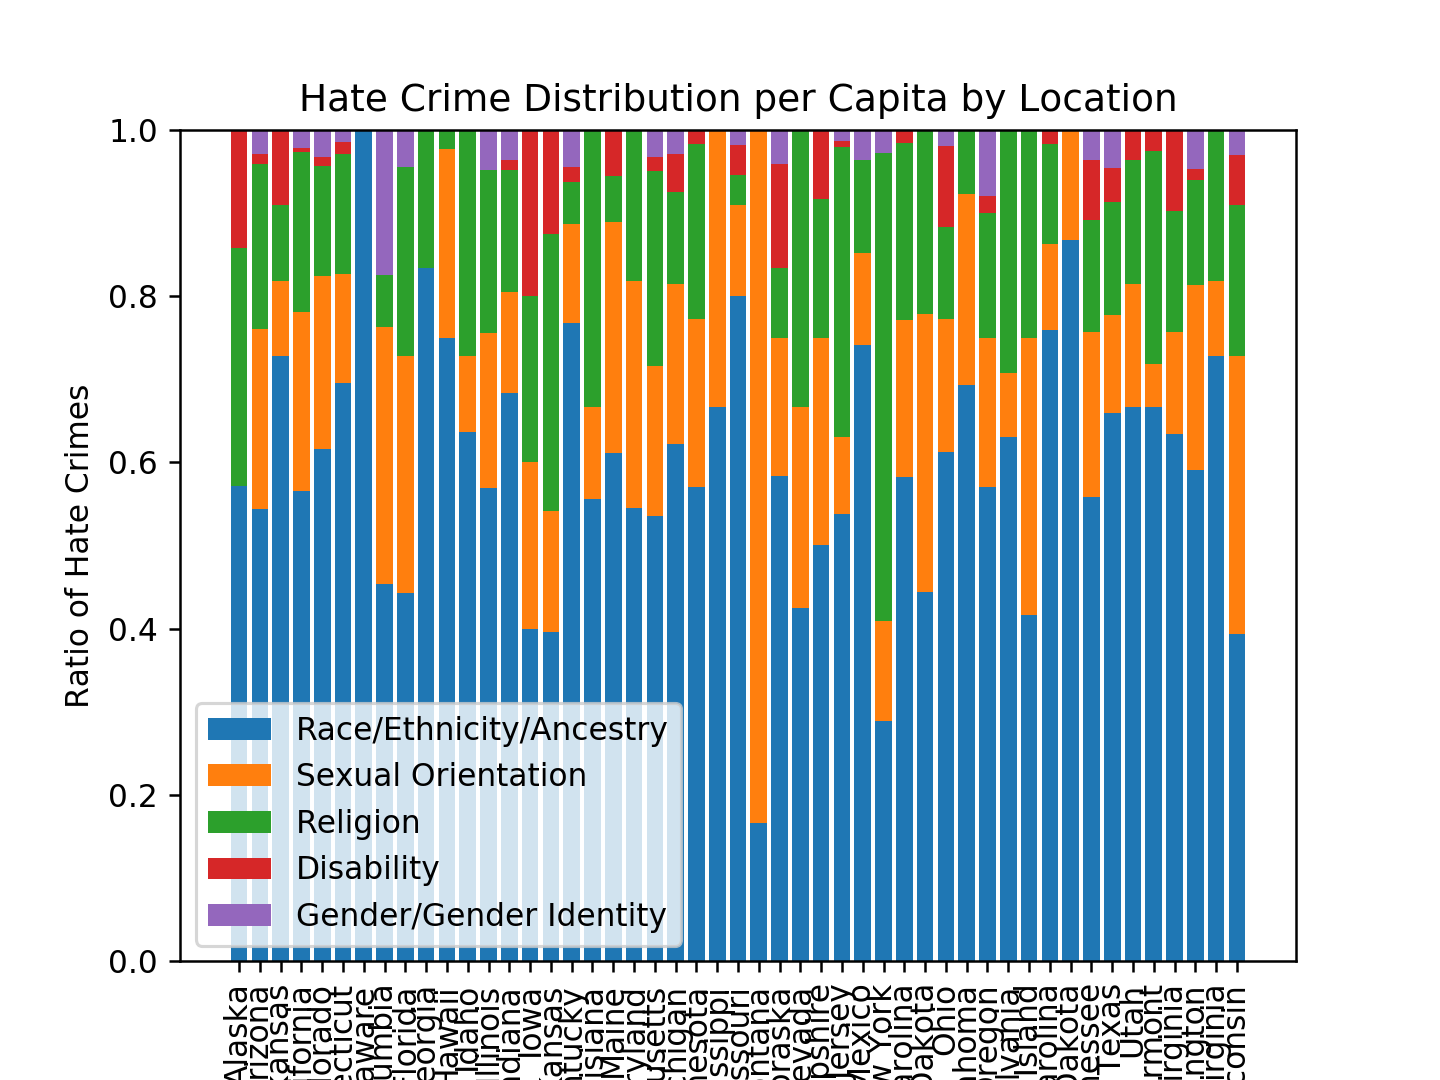

In [9]:
dfgpop["Total"] = dfgpop.sum(axis=1)

for x in dfgpop.columns:
    dfgpop[x] = dfgpop[x]/dfgpop["Total"]

race = plt.bar(range(dfg.shape[0]),dfgpop["Race/Ethnicity/Ancestry"])
sex = plt.bar(range(dfg.shape[0]),dfgpop["Sexual Orientation"],bottom=dfgpop["Race/Ethnicity/Ancestry"])
rel = plt.bar(range(dfg.shape[0]),dfgpop["Religion"], bottom = dfgpop["Race/Ethnicity/Ancestry"]+ dfgpop["Sexual Orientation"])
dis = plt.bar(range(dfg.shape[0]),dfgpop["Disability"], bottom = dfgpop["Race/Ethnicity/Ancestry"] + dfgpop["Sexual Orientation"]+ dfgpop["Religion"])
gen = plt.bar(range(dfg.shape[0]),dfgpop["Gender"] + dfgpop["Gender identity"], bottom = dfgpop["Race/Ethnicity/Ancestry"]+ dfgpop["Sexual Orientation"] + dfgpop["Religion"] + dfgpop["Disability"])

ind = list(dfg.index)
plt.xticks(range(dfg.shape[0]),labels=ind, rotation = 90)
plt.title("Hate Crime Distribution per Capita by Location")
plt.legend((race,sex,rel,dis,gen),("Race/Ethnicity/Ancestry","Sexual Orientation","Religion","Disability","Gender/Gender Identity"))
plt.ylabel("Ratio of Hate Crimes")
plt.xlabel("Location")
plt.show()

In [108]:
f = gmaps.figure()
l = gmaps.symbol_layer(loc)
f.add_layer(l)
f

Figure(layout=FigureLayout(height='420px'))

In [6]:
f1 = gmaps.figure()
l = gmaps.heatmap_layer(loc, weights=dfa["Population"])
f1.add_layer(l)
f1

Figure(layout=FigureLayout(height='420px'))

In [14]:
from census_vars import censuskey
censusval = dict()
for k,v in censuskey.items():
    censusval[v]=k
censusval

{'B19013_001E': 'income',
 'B19301_001E': 'income_per_capita',
 'B23025_002E': 'employment_labor_force',
 'B23025_007E': 'employment_not_labor_force',
 'B23025_003E': 'employment_civilian_labor_force',
 'B23025_004E': 'employment_employed',
 'B23025_005E': 'employment_unemployed',
 'B23025_006E': 'employment_armed_forces',
 'C24010_003E': 'employment_male_management_business_science_and_arts_occupations',
 'C24010_004E': 'employment_male_management_business_and_financial_occupations',
 'C24010_005E': 'employment_male_management_occupations',
 'C24010_006E': 'employment_male_business_and_financial_operations_occupations',
 'C24010_007E': 'employment_male_computer_engineering_and_science_occupations',
 'C24010_008E': 'employment_male_computer_and_mathematical_occupations',
 'C24010_009E': 'employment_male_architecture_and_engineering_occupations',
 'C24010_010E': 'employment_male_life_physical_and_social_science_occupations',
 'C24010_011E': 'employment_male_education_legal_community_ser

In [31]:
cd = c.acs.get(("NAME", "B19013_001E", "B01003_001E", "B01002_001E", "B19301_001E", "B17001_002E", "B23025_005E","B16001_002E"), {'for': 'state:*'})
dfcd = pd.DataFrame(cd)
cols = list(dfcd.columns)
i = 0
for co in cols:
    if co == "NAME":
        cols[i] = "State"
    if co in censusval:
        cols[i] = censusval[co]
    i = i + 1
dfcd.columns = cols
del dfcd["state"]
dfcd

,State,income,population,age,income_per_capita,poverty,employment_unemployed,language_speak_only_english
0,Minnesota,68411.0,5527358.0,37.9,36245.0,547442.0,119218.0,4571735.0
1,Mississippi,43567.0,2988762.0,37.2,23434.0,599795.0,110036.0,2691455.0
2,Missouri,53560.0,6090062.0,38.5,29537.0,837930.0,155958.0,5367705.0
3,Montana,52559.0,1041732.0,39.8,29765.0,139063.0,22433.0,939716.0
4,Nebraska,59116.0,1904760.0,36.4,31101.0,213790.0,36545.0,1574067.0
5,Nevada,57598.0,2922849.0,37.9,29961.0,393431.0,101748.0,1907502.0
6,New Hampshire,74057.0,1343622.0,42.7,38548.0,102352.0,30392.0,1178986.0
7,New Jersey,79363.0,8881845.0,39.8,40895.0,904132.0,285084.0,5769902.0
8,New Mexico,48059.0,2092434.0,37.5,26085.0,410389.0,68370.0,1281412.0
9,New York,65323.0,19618453.0,38.7,37470.0,2797985.0,602636.0,12830019.0


In [42]:
dfrace = pd.merge(dfg,dfcd, how="left",on=["State","State"])
dfrace

,State,Race/Ethnicity/Ancestry,Religion,Sexual Orientation,Disability,Gender,Gender identity,1st quarter,3rd quarter,4th quarter,Population,Total,income,population,age,income_per_capita,poverty,employment_unemployed,language_speak_only_english
0,Alaska,4,2,0,1,0,0,1.0,4.0,0.0,358822.0,7,76715.0,738516.0,34.0,35874.0,77865.0,28067.0,573373.0
1,Arizona,93,34,37,2,2,3,51.0,35.0,36.0,4275253.0,171,56213.0,6946685.0,37.4,29265.0,1092192.0,210214.0,4740041.0
2,Arkansas,8,1,1,1,0,0,4.0,1.0,2.0,342312.0,11,45726.0,2990671.0,37.9,25635.0,510337.0,75774.0,2593351.0
3,California,544,185,208,5,4,17,212.0,265.0,228.0,24792513.0,963,71228.0,39148760.0,36.3,35021.0,5487141.0,1321502.0,20487071.0
4,Colorado,56,12,19,1,0,3,15.0,21.0,19.0,2398112.0,91,68811.0,5531141.0,36.6,36415.0,590504.0,139326.0,4314327.0
5,Connecticut,48,10,9,1,1,0,9.0,18.0,22.0,1307105.0,69,76106.0,3581504.0,40.8,43056.0,348449.0,125909.0,2643514.0
6,Delaware,9,0,0,0,0,0,3.0,2.0,1.0,182449.0,9,65627.0,949495.0,40.2,33989.0,109798.0,28501.0,778595.0
7,District of Columbia,88,12,60,0,1,33,32.0,58.0,55.0,702455.0,194,82604.0,684498.0,33.9,53321.0,109497.0,29373.0,528179.0
8,Florida,39,20,25,0,0,4,20.0,31.0,20.0,4343839.0,88,53267.0,20598139.0,41.9,30197.0,2983851.0,622978.0,13810811.0
9,Georgia,5,1,0,0,0,0,1.0,2.0,0.0,550845.0,6,55679.0,10297484.0,36.5,29523.0,1607714.0,322854.0,8301923.0


<IPython.core.display.Javascript object>


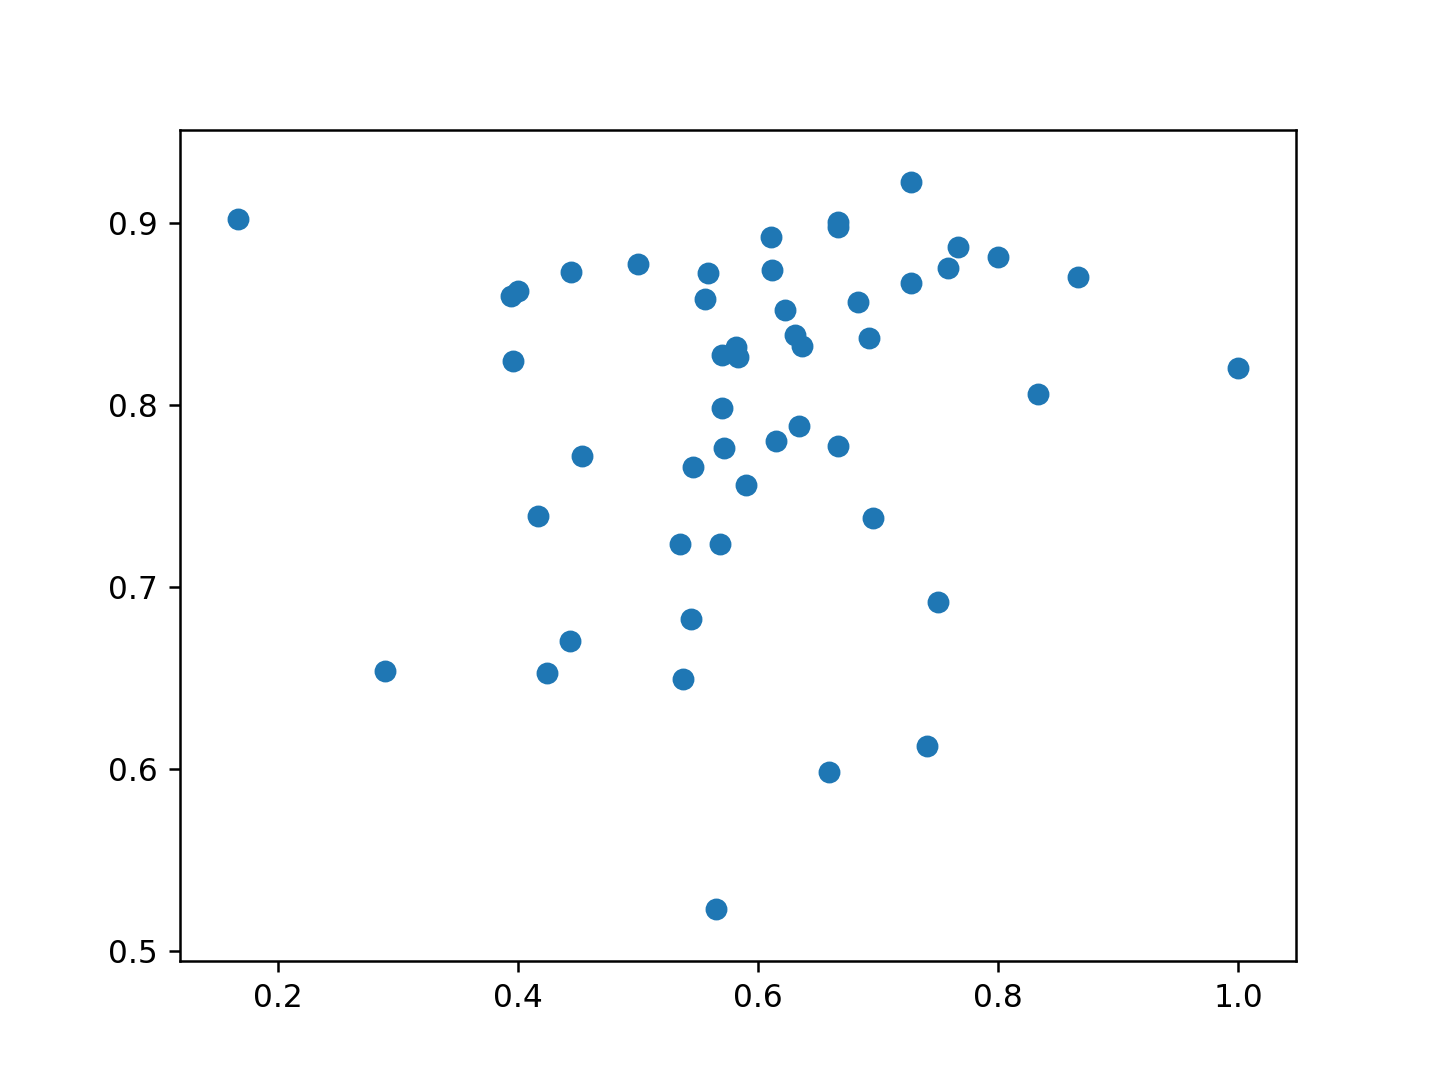

In [40]:
dfrace["PercentEnglish"] = dfrace.language_speak_only_english / dfrace.population
dfrace = dfrace.loc[:,["State","Race/Ethnicity/Ancestry","PercentEnglish"]]
dfrace

plt.scatter(dfrace["Race/Ethnicity/Ancestry"],dfrace["PercentEnglish"])

<IPython.core.display.Javascript object>


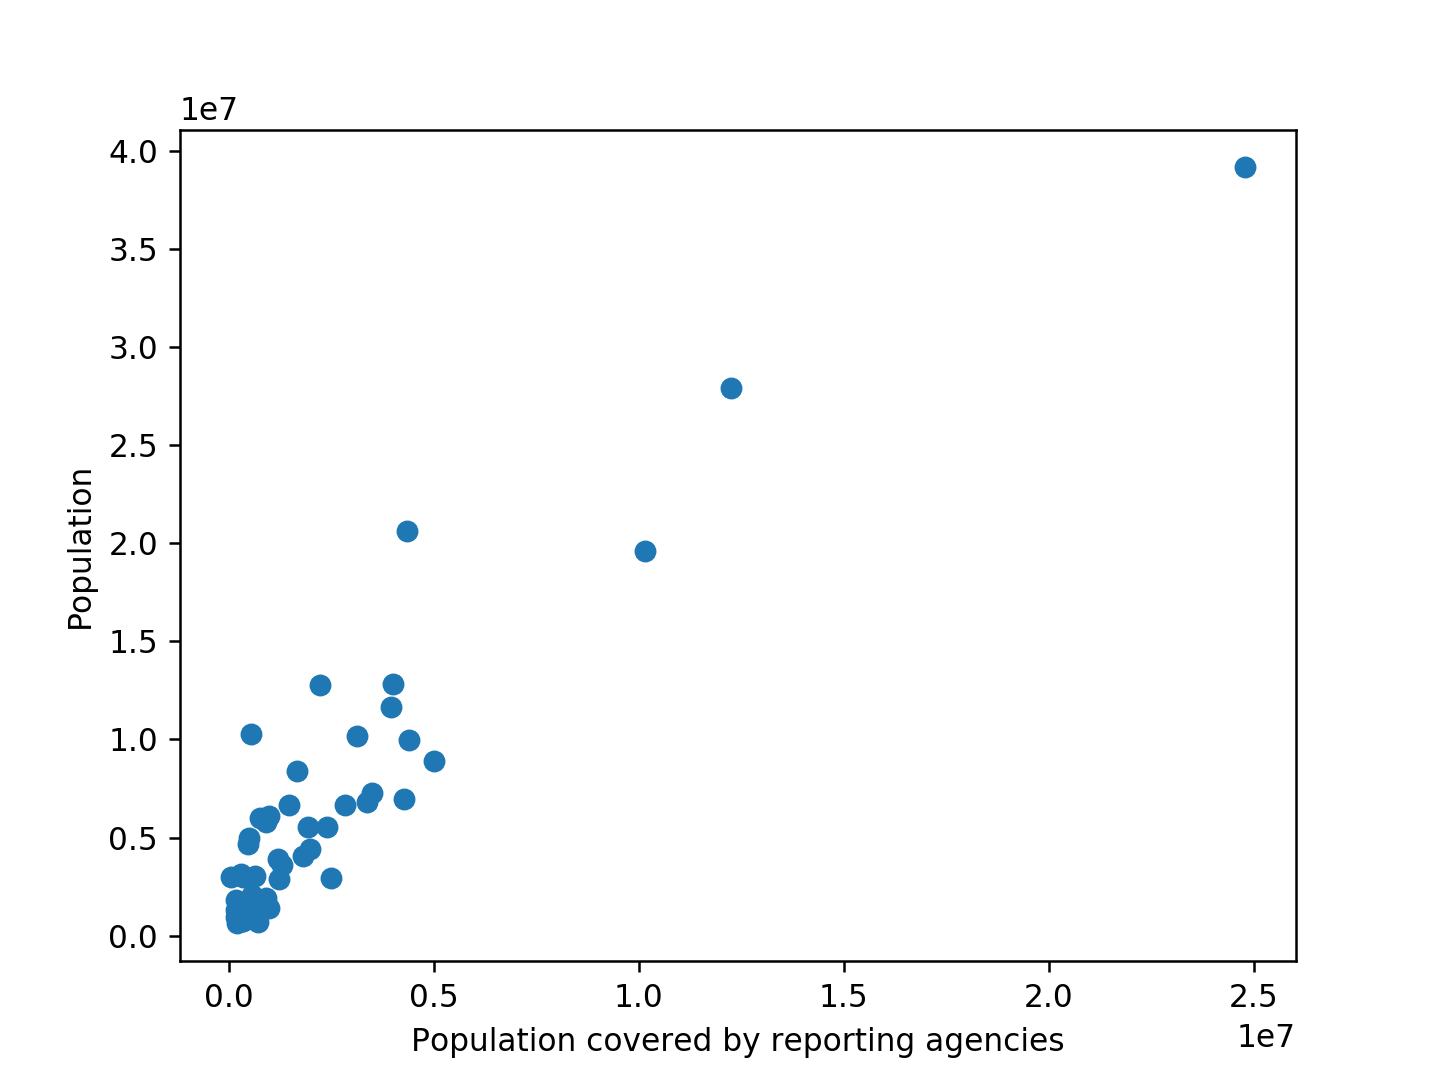

Text(0, 0.5, 'Population')

In [43]:
plt.scatter(dfrace["Population"],dfrace["population"])
plt.xlabel("Population covered by reporting agencies")
plt.ylabel("Population")

<IPython.core.display.Javascript object>


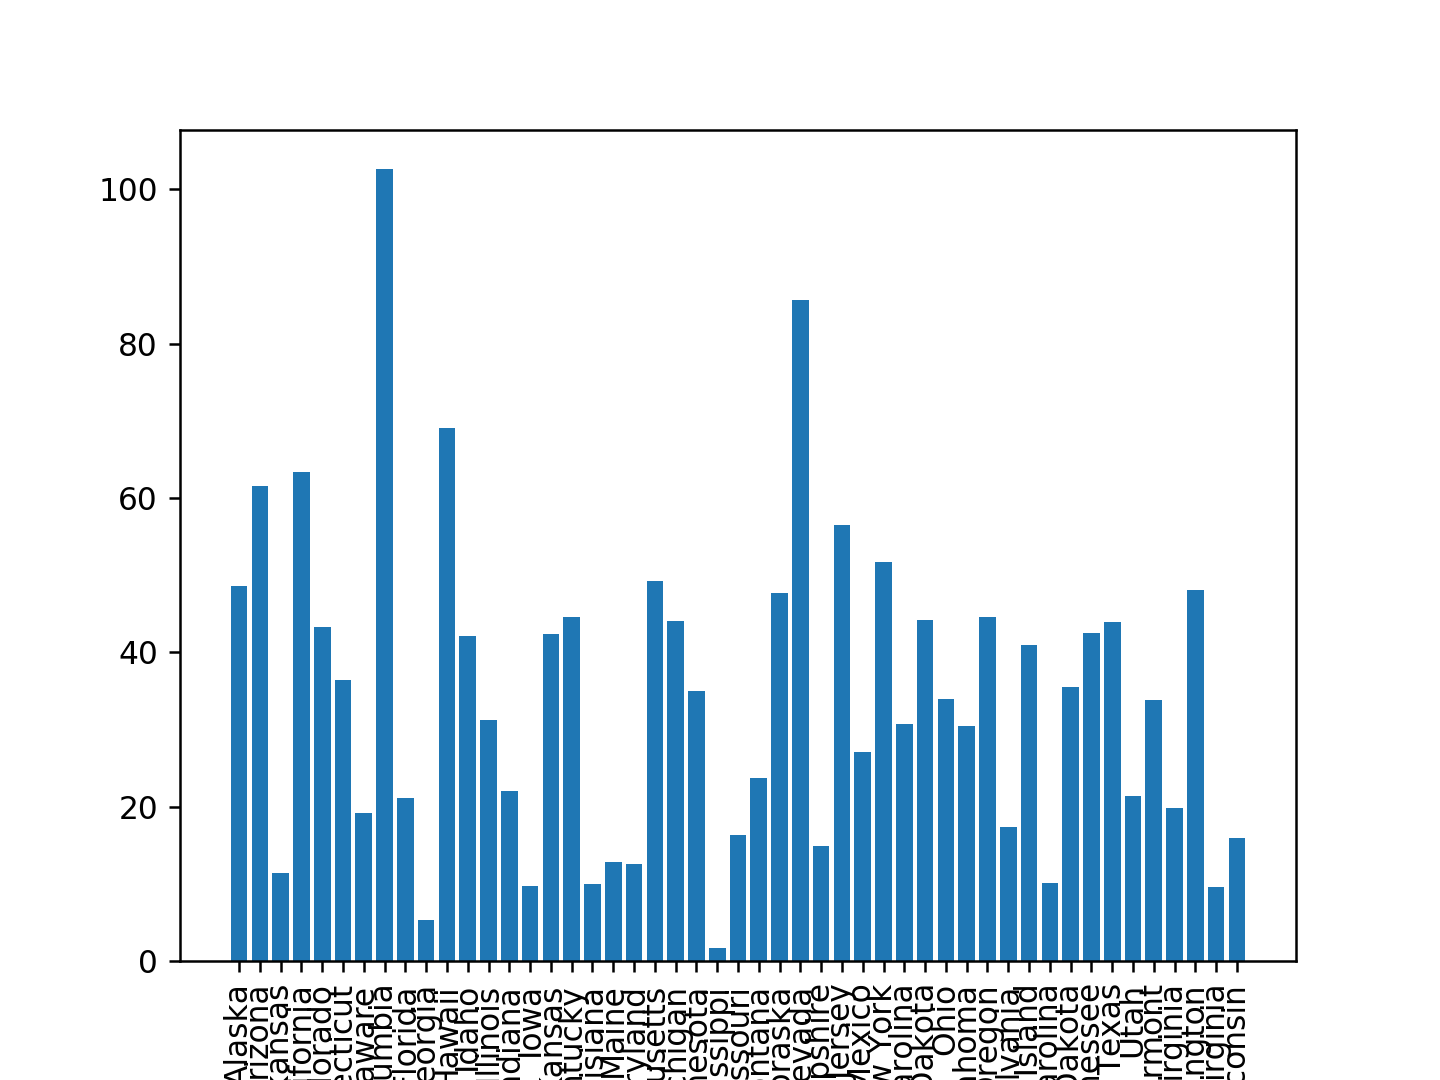

In [50]:
dfrace["PerPop"] = dfrace["Population"]/dfrace["population"]*100

plt.bar(range(dfrace.shape[0]),dfrace["PerPop"])

ind = list(dfg.index)
plt.xticks(range(dfg.shape[0]),labels=ind, rotation = 90)
plt.show()

In [51]:
dfrace[["State","PerPop"]].sort_values("PerPop")

,State,PerPop
23,Mississippi,1.653527
9,Georgia,5.349316
47,West Virginia,9.582331
14,Iowa,9.792788
17,Louisiana,9.980903
39,South Carolina,10.145331
2,Arkansas,11.445993
19,Maryland,12.542669
18,Maine,12.839686
28,New Hampshire,14.873528
